In [3]:
from funsor import Funsor
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import jax.scipy as jsp 
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.contrib.funsor import config_enumerate
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 
from typing import NamedTuple, Any
import funsor 
import pyro


print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))
print("NumPyro version: {}".format(numpyro.__version__))
print("Funsor version: {}".format(funsor.__version__))
print("pyro version: {}".format(pyro.__version__))


import os 

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={4}"


JAX version: 0.4.28
blackjax version: 1.2.0
NumPyro version: 0.16.1
Funsor version: 0.4.5
pyro version: 1.9.1


In [24]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

RANDOM_SEED = 7
rng = np.random.default_rng(RANDOM_SEED)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

# x = random.normal(key, shape=(n,))*3
x = jnp.array(rng.normal(loc=0, scale=1, size=n), dtype=jnp.float32)
# x = jnp.array(rng.normal(loc=0, scale=3, size=n), dtype=jnp.float32)
# x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
x2 = jnp.array(rng.binomial(n=1, p=.1, size=n), dtype=jnp.float32)
# idx_pairs = list(combinations(range(len(x)), 2))
# x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
# x_diff = (x_diff - x_diff.mean()) / x_diff.std()
# x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])
def compute_pairwise_diffs(x, x2):
    # Get upper triangle indices
    idx = jnp.triu_indices(n=x.shape[0], k=1)
    
    # Compute absolute differences
    x_diff = jnp.abs(x[idx[0]] - x[idx[1]])
    
    # Compute OR operation for x2
    # Using XOR (^) and AND (&) to implement OR for binary values
    x2_or = (x2[idx[0]] + x2[idx[1]] == 1).astype(jnp.float32)
    
    return x_diff, x2_or

x_diff, x2_or = compute_pairwise_diffs(x, x2)


print("x2 mean (std)", x2.mean(), x2.std())
print("x2_or mean (std)", x2_or.mean(), x2_or.std())
print("x_diff mean (std)", x_diff.mean(), x_diff.std())

print(x.shape, x2.shape, x_diff.shape, x2_or.shape)




# U = jnp.array(rng.normal(loc=0, scale=1, size=n))

# @jax.jit
# def latent_to_norm_of_diff(U):
#     idx = jnp.triu_indices(n=U.shape[0], k=1)
#     # U_diff = U[idx[0]] - U[idx[1]]
#     # print(U_diff.shape)
#     # return jnp.linalg.norm(U_diff, axis=1)
#     return jnp.abs(U[idx[0]] - U[idx[1]])

# U_norm = latent_to_norm_of_diff(U)
# print(U_norm.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))

# theta = jnp.array([-2.5, -0.25, 1])
# theta = jnp.array([-2.5, 0, 1])
theta = jnp.array([-2.5, 1])


# theta = jnp.array([-2.5, -0.3, 1])
# theta = jnp.array([-2.5, -0.5, 2])

# theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
# gamma = jnp.array([logit(0.7), logit(0.2), 0.1, -0.5])

# gamma = jnp.array([logit(0.7), logit(0.2), 0.3, -0.5])
# gamma = jnp.array([logit(0.7), logit(0.1), 0.35])
gamma = jnp.array([logit(0.9), logit(0.1), .2])
# gamma = jnp.array([logit(0.9), logit(0.1), 2])

# gamma = jnp.array([logit(0.7), logit(0.2), 0.1, 0])

# gamma = jnp.array([logit(.85), logit(.15)])

# triu_star_probs = expit(jnp.dot(df_edges, theta) - U_norm)
# triu_star_probs = expit(jnp.dot(df_edges, theta))

triu_star_probs = expit(theta[0] + theta[1]*x2_or)
# triu_star_probs = expit(theta[0] + theta[1]*x2_or - U_norm)

print("triu_dim == triu_star_probs.shape[0]", triu_dim == triu_star_probs.shape[0])

# triu_star_probs = expit(theta[0] + theta[1]*x2_or - U_norm)
# triu_star_probs = expit(theta[0] + theta[2]*x2_or)

# triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))
print("mean (Std) triu_star_probs: ", triu_star_probs.mean(), triu_star_probs.std())

triu_star = jnp.array(rng.binomial(n=1, p=triu_star_probs, size=triu_dim), dtype=jnp.float32)

print("mean (std) triu_star values: ", triu_star.mean(), triu_star.std())
# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:]))
triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + gamma[2]*x_diff))


# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
# triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
# triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))
triu_obs = jnp.array(rng.binomial(n=1, p=triu_obs_probs, size=triu_dim), dtype = jnp.float32)

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)
    # expos = aux.zeigen_value(Z, deg_cen, mat_star)
    # return (expos - jnp.mean(expos)) / jnp.std(expos)

mat_star = aux.Triu_to_mat(triu_star)
# Z = random.binomial(key, n=1, p=0.5, shape=(n,))
Z = jnp.array(rng.binomial(n=1, p=0.5, size=n), dtype=jnp.float32)
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)
print("exposures mean (std): ", exposures.mean(), exposures.std())

# eta = jnp.array([-1, 3, -0.25, 1, 3])
eta = jnp.array([-1, 3, -0.25, 2])
# eta = jnp.array([-1, 3, -0.25, 1])
# df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, x2, exposures]))
df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))


mean_y = jnp.dot(df_nodes, eta)

print("mean (std) mean_y: ", mean_y.mean(), mean_y.std())

@jax.jit
def CAR_cov(triu_vals, sig_inv, rho):
    # Cov(Y) = \Sigma = sig_inv * (D - rho*A)^-1
    # So precision = \Sigma^{-1} = (1/sig_inv) * (D - rho*A)
    adj_mat = aux.Triu_to_mat(triu_vals)
    degs_diag = jnp.sum(adj_mat, axis=1) * jnp.eye(adj_mat.shape[0])
    # return sig_inv * (degs_diag - rho * adj_mat)
    precis_ = sig_inv * (degs_diag - rho * adj_mat)
    return jnp.linalg.inv(precis_)

rho = 0.5
sig_inv = 2/3 # 1/sigma^2
# sig_inv = 1 # 1/sigma^2
# Y_precis_mat = CAR_precision(triu_star, sig_inv, rho)
# Y_cov = jnp.linalg.inv(Y_precis_mat)
Y_cov = CAR_cov(triu_star, sig_inv, rho)
# print("Sigma^{-1} shape", Y_precis_mat.shape,
    #   "Sigma shape", Y_cov.shape)  

print("Y_cov mean (std): ", Y_cov.mean(), Y_cov.std())

# sig_y = 1.0

# Y = random.normal(key, shape=(n,))*sig_y + mean_y
# Y =  jnp.array(mean_y + rng.normal(loc=0, scale=sig_y, size=n), dtype=jnp.float32)

Y = jnp.array(rng.multivariate_normal(mean_y, Y_cov), dtype=jnp.float32)


print("Y mean (std): ", Y.mean(), Y.std())


print(Y.shape)

class DataTuple(NamedTuple):
    x: jnp.ndarray
    x2: jnp.ndarray
    x_diff: jnp.ndarray
    x2_or: jnp.ndarray
    triu_star: jnp.ndarray
    triu_obs: jnp.ndarray
    Z: jnp.ndarray
    exposures: jnp.ndarray
    Y: jnp.ndarray

class ParamTuple(NamedTuple):
    theta: jnp.ndarray
    gamma: jnp.ndarray
    eta: jnp.ndarray
    # sig_y: float
    rho: float
    sig_inv: float
    # U: jnp.ndarray
    # U_norm: jnp.ndarray

data = DataTuple(x, x2, x_diff, x2_or, triu_star, triu_obs, Z, exposures, Y)

# param = _param(theta, gamma, eta, sig_y)
param = ParamTuple(theta, gamma, eta, rho, sig_inv)
# param = ParamTuple(theta, gamma, eta, rho, sig_inv, U, U_norm)

x2 mean (std) 0.1 0.29999998
x2_or mean (std) 0.1803607 0.38448763
x_diff mean (std) 1.0608035 0.79623026
(500,) (500,) (124750,) (124750,)
triu_dim == triu_star_probs.shape[0] True
mean (Std) triu_star_probs:  0.095078744 0.040973827
mean (std) triu_star values:  0.09423647 0.2921574
(124750,) (124750,)
exposures mean (std):  2.3902886 0.6747556
mean (std) mean_y:  5.27066 2.019354
Y_cov mean (std):  0.00013187254 0.0015737242
Y mean (std):  5.275341 2.0237236
(500,)


In [37]:
nn = 1000
print(nn*(nn-1)//2)

499500


mean exposure:  2.3902886 
 std exposure:  0.6747556 
 median exposure:  2.2925851


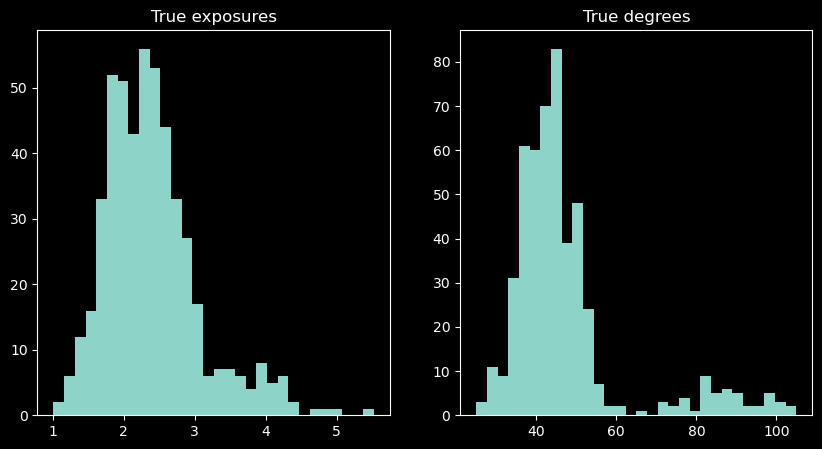

In [26]:
# panel of two plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot 1
axs[0].hist(exposures, bins=30)
axs[0].set_title("True exposures")

# plot 2
axs[1].hist(jnp.sum(mat_star, axis=1), bins=30)
axs[1].set_title("True degrees")

print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

cor obs~true:  0.69658864


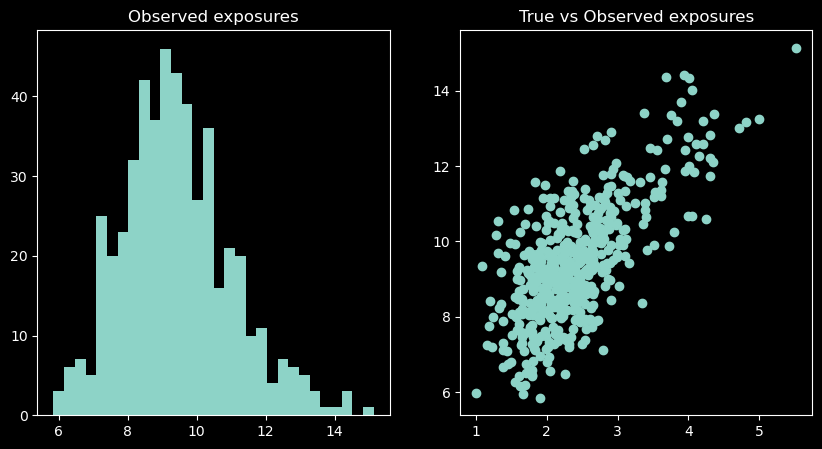

In [27]:
expos_obs = compute_exposures(triu_obs, Z)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(expos_obs, bins=30)
axs[0].set_title("Observed exposures")

axs[1].scatter(exposures, expos_obs)
axs[1].set_title("True vs Observed exposures")

print("cor obs~true: ", jnp.corrcoef(exposures, expos_obs)[0, 1])
# create y~x line
# x_line = np.linspace(min(exposures), max(exposures), 100)
# y_line = x_line
# plt.plot(x_line, y_line, color='red')

cor Y~exposures:  0.6615024 
 cor Y~observed exposures:  0.44914648


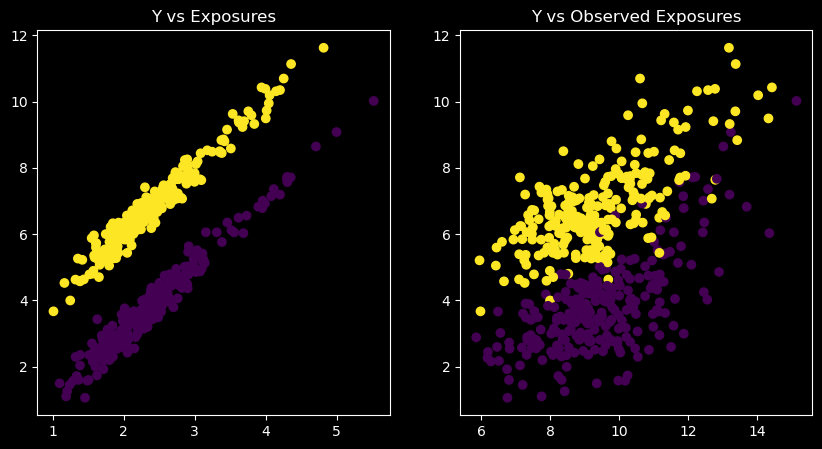

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].scatter(exposures, Y, c=Z)
axs[0].set_title("Y vs Exposures")

axs[1].scatter(expos_obs, Y, c=Z)
axs[1].set_title("Y vs Observed Exposures")

print("cor Y~exposures: ", jnp.corrcoef(Y, exposures)[0, 1], "\n",
        "cor Y~observed exposures: ", jnp.corrcoef(Y, expos_obs)[0, 1])

In [7]:
@jax.jit
def car_logdensity(y, mu, sigma, rho, adj_matrix):
    """Compute log density of CAR model
    
    Args:
        y: array of shape (n,) - observed values
        mu: array of shape (n,) - mean parameter
        sigma: float - conditional precision parameter (positive)
        rho: float - correlation parameter in [0,1]
        adj_matrix: array of shape (n,n) - symmetric adjacency matrix
    
    Returns:
        float: log density value
    """
    # Center the observations
    y_centered = y - mu
    
    # Compute degree matrix diagonal
    D = adj_matrix.sum(axis=-1)
    # replace D==0 with 1.0. 
    D = jnp.where(D == 0, 1.0, D)
    D_rsqrt = D ** (-0.5)
    
    # Compute normalized adjacency matrix for eigenvalues
    adj_scaled = adj_matrix * (D_rsqrt[:, None] * D_rsqrt[None, :])
    
    # Get eigenvalues of normalized adjacency
    lam = jnp.linalg.eigvalsh(adj_scaled)
    
    n = y.shape[0]
    
    # Compute components of log density
    logprec = n * jnp.log(sigma)
    logdet = jnp.sum(jnp.log1p(-rho * lam)) + jnp.sum(jnp.log(D))
    
    # Compute quadratic form
    # quad = sigma * jnp.sum(
    #     y_centered * (D * y_centered - rho * (adj_matrix @ y_centered))
    # )

    quad = sigma * (
    jnp.sum(D * y_centered**2) - 
    rho * jnp.sum(y_centered * (adj_matrix @ y_centered))
    )

    # quad = sigma * (
    # jnp.einsum('i,i,i->', D, y_centered, y_centered) -
    # rho * jnp.einsum('i,ij,j->', y_centered, adj_matrix, y_centered)
    # )

    return 0.5 * (-n * jnp.log(2 * jnp.pi) + logprec + logdet - quad)

In [8]:
log_car = car_logdensity(Y, mean_y, sig_inv, rho, mat_star)
y_cov = CAR_cov(data.triu_star, param.sig_inv, param.rho)
log_y_manual = jsp.stats.multivariate_normal.logpdf(Y, mean_y, y_cov).sum()
log_y_numpyro = dist.CAR(loc=mean_y,
                        correlation=param.rho,
                            conditional_precision=param.sig_inv,
                            adj_matrix = aux.Triu_to_mat(data.triu_star)).log_prob(Y).sum()

print("CAR log density (manual): ", log_car, "\n",
        "CAR log density (numpyro): ", log_y_numpyro, "\n",
        "Y log density (manual): ", log_y_manual)

CAR log density (manual):  139.71126 
 CAR log density (numpyro):  139.71126 
 Y log density (manual):  139.7113


In [9]:
@jax.jit
# def cond_logpost_a_star(triu_star, triu_obs, x_diff, x2_or, theta, gamma, Y, X, Z, eta, sig_y):
def cond_logpost_a_star(triu_star, data, param):    
    # p(A*|X,\theta)
    logits_a_star = param.theta[0] + param.theta[1]*data.x2_or
    a_star_logpmf = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    # p(A|A*,X,\gamma)
    logits_a_obs = (triu_star * param.gamma[0]) + (1 - triu_star) * (param.gamma[1] + param.gamma[2]*data.x_diff)
    a_obs_logpmf = data.triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    # p(Y|A*,X,Z,\eta,\sig_y)
    exposures = compute_exposures(triu_star, data.Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), data.Z, data.x, exposures]))
    mean_y = jnp.dot(df_nodes, param.eta)

    # optimze CAR logpdf code using tricks and jax.jit (build manual func)
    # y_logpdf = jsp.stats.norm.logpdf(data.Y, loc=mean_y, scale=param.sig_y)
    # y_cov = CAR_cov(triu_star, param.sig_inv, param.rho)
    # y_logpdf = jsp.stats.multivariate_normal.logpdf(data.Y, mean_y, y_cov)
    y_logpdf = car_logdensity(data.Y, mean_y, param.sig_inv, param.rho, aux.Triu_to_mat(triu_star))
    
    # return a_star_logpmf.sum() + a_obs_logpmf.sum() + y_logpdf.sum()
    return a_star_logpmf.sum() + a_obs_logpmf.sum() + y_logpdf
    
# post_val_grad_fn = jax.value_and_grad(cond_logpost_a_star)
post_val_grad_fn = jax.jit(jax.value_and_grad(cond_logpost_a_star))




() (124750,)
-100002.54 
 [-3.7242203  -4.2253904  -3.7770278  -3.2717068   0.82740974 -3.3951647
 -4.309957    0.6328318  -4.2959533 ]
CPU times: total: 12.8 s
Wall time: 6.86 s


Text(0.5, 1.0, 'Scores')

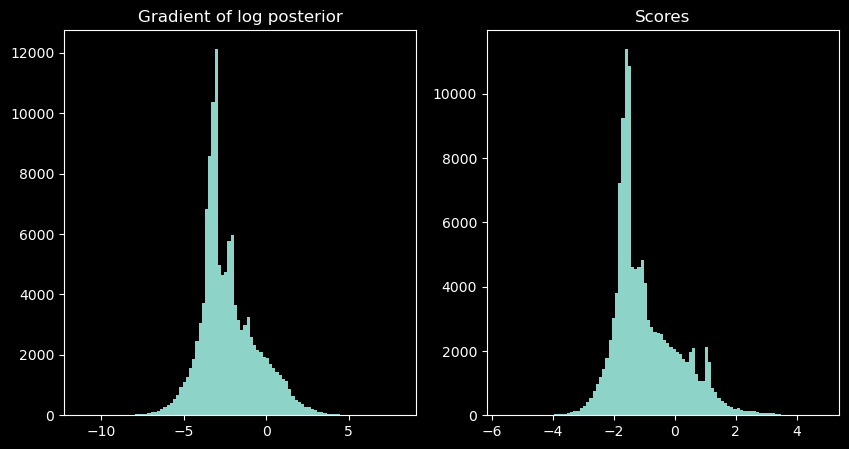

In [10]:
%%time

# logpost_sum, gradient = post_val_grad_fn(triu_star,
#                                         triu_obs,
#                                         # df_edges,
#                                         x_diff,
#                                         x2_or,
#                                         theta,
#                                         gamma, 
#                                         Y, x, Z, eta, sig_y)

logpost_sum, gradient = post_val_grad_fn(triu_star,
                                         data,
                                         param)
print(logpost_sum.shape, gradient.shape)
print(logpost_sum, "\n", gradient[1:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# create histogram of gradient

axs[0].hist(gradient, bins=100)
axs[0].set_title("Gradient of log posterior")

# create histogram of scores
score_grad = -(2*triu_star-1)*gradient/2
axs[1].hist(score_grad, bins=100)
axs[1].set_title("Scores")


In [11]:

TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .0005
# BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
BATCH_LEN = 5
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = 4*jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)
# N_STEPS = 10
N_STEPS = 5


@jax.jit
def weighted_sample_and_logprobs(key, scores):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    # selected_indices = jnp.argsort(-perturbed)[:M]
    _, selected_indices = jax.lax.top_k(perturbed, BATCH_LEN)  


     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()

class IPState(NamedTuple):
    positions: Any
    logdensity: Any
    logdensity_grad: Any
    scores: Any
    # logdensity: float
    # logdensity_grad: float
    # scores: float

class IPInfo(NamedTuple):
    acceptance_rate: Any
    is_accepted: Any

# TODO: test if running multiple smaller steps (without accept/reject)
#       and then accept/reject at the end is better (HMC style...)

# def GWG_kernel(rng_key, state, triu_obs, x_diff, x2_or, theta, gamma,
#                       Y, X, Z, eta, sig_y, step_size = 0.0, n_steps=10,
#                       valgrad_fn = post_val_grad_fn):

@jax.jit
def GWG_step(rng_key, state, data, param):
    key1, key2 = random.split(rng_key, 2)
    # sample idx to propose edge flip
    idx, forward_logprob = weighted_sample_and_logprobs(key1, state.scores)
    new_triu_star = state.positions.at[idx].set(1 - state.positions[idx])

    # backward proposal
    f_proposed, backward_grad = post_val_grad_fn(new_triu_star, data, param)
    backward_scores = (-(2*new_triu_star-1)*backward_grad)/2

    backward_logprob = propsal_logprobs(idx, backward_scores)

    # accept/reject
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity + backward_logprob - forward_logprob),min=1)
    acceptance_ratio = jnp.minimum(jnp.exp(f_proposed - state.logdensity + backward_logprob - forward_logprob), 1)
    accept = random.uniform(key2) <= acceptance_ratio

    # update state and info
    new_triu_star = jax.lax.select(accept, new_triu_star, state.positions)
    new_logpost = jax.lax.select(accept, f_proposed, state.logdensity)
    new_grad = jax.lax.select(accept, backward_grad, state.logdensity_grad)
    new_scores = jax.lax.select(accept, backward_scores, state.scores)
    
    state = IPState(new_triu_star, new_logpost, new_grad, new_scores)
    info = IPInfo(acceptance_ratio, accept)

    return state, info


@jax.jit
def GWG_kernel(rng_key, state, data, param):
    def body_fun(carry, _):
        rng_key, cur_state = carry
        rng_key, step_key = random.split(rng_key)
        new_state, info = GWG_step(step_key, cur_state, data, param)
        return (rng_key, new_state), info

    # Run the scan
    (_, final_state), final_info = jax.lax.scan(
        body_fun,
        (rng_key, state),
        jnp.arange(N_STEPS)
        # jnp.arange(n_steps)
    )
    
    return final_state, final_info

     
@jax.jit
def DMALA_kernel(rng_key, triu_star, triu_obs, df_edges, theta, gamma,
                 Y, X, Z, eta, sig_y, step_size = 1.0, eps=1e-8):
    key1, key2, key3 = random.split(rng_key, 3)
    # sample idx to propose edge flip
    idx = random.choice(key1, TRIU_LEN, (BATCH_LEN,), replace=False)

    # compute baseline log-posterior and gradient
    (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma,
                                                 Y, X, Z, eta, sig_y)
    baseline_scores = (-(2*triu_star-1)*baseline_grad)/2
    baseline_scores = baseline_scores[idx]
    baseline_std_scores = jnp.exp(baseline_scores - step_size)
    baseline_std_scores = jnp.clip(baseline_std_scores, -20, 20)
    
    # flip probablities
    baseline_flip_probs = baseline_std_scores / (1 + baseline_std_scores)

    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < baseline_flip_probs
    
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = baseline_flip_probs * flip_indicator + (1 - baseline_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx].set(flip_indicator * (1 - triu_star[idx]) +
                                              (1 - flip_indicator) * triu_star[idx])

    # compute log-posterior and gradient for proposed triu_star
    (f_proposed,_), proposed_grad = val_grad_fn(new_triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    proposed_scores = (-(2*new_triu_star-1)*proposed_grad)/2
    proposed_scores = proposed_scores[idx]
    proposed_std_scores = jnp.exp(proposed_scores - step_size)
    proposed_std_scores = jnp.clip(proposed_std_scores, -20, 20)
    backward_probs = proposed_std_scores / (1 + proposed_std_scores)

    # compute backward proposal q(A*_t|\tilde{A}*_t)
    backward_propsal = jnp.sum(jnp.log(backward_probs + eps))

    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_propsal - forward_proposal),
                                a_max=1)
    
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    new_grad = jax.lax.select(accept, proposed_grad, baseline_grad)
    state = IPState(new_triu_star, new_logpost, new_grad)
    info = IPInfo(acceptance_ratio, accept)
    
    return state, info
    



5


In [12]:
@jax.jit
# def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, adapt_rate=0.01):
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, adapt_rate=0.0):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    # adjustment = gamma * (target_rate - acceptance_rate)
    # return alpha + adjustment
    log_alpha = jnp.log(alpha)
    log_alpha += adapt_rate * (acceptance_rate - target_rate)
    return jnp.exp(log_alpha)

In [13]:
%%time 


# get init state
triu_star_noisy = triu_obs
# f_init, grad_init = post_val_grad_fn(triu_star_noisy, triu_obs, x_diff, x2_or,
#                                     theta, gamma, Y, x, Z, eta, sig_y)

f_init, grad_init = post_val_grad_fn(triu_star_noisy, data, param)

init_scores = (-(2*triu_star_noisy-1)*grad_init)/2
init_state = IPState(triu_star_noisy, f_init, grad_init, init_scores)


@jax.jit
def run_gwg_chain(init_key, init_state, data, param, n_iterations=1000):
    def scan_body(carry, _):
        key, state = carry
        key, step_key = random.split(key)
        new_state, info = GWG_kernel(step_key, state, data, param)
        
        # Return both carry and the complete state and info
        return (key, new_state), (new_state, info)

    # Run the scan for n_iterations
    (_, _), (states, infos) = jax.lax.scan(
        scan_body,
        (init_key, init_state),
        jnp.zeros(n_iterations, dtype=jnp.int32)
    )

    return states, infos

# Usage:

key = random.split(key)[0]
chain_states, chain_infos = run_gwg_chain(
    init_key=key,
    init_state=init_state,
    data=data,
    param=param
)

# 

CPU times: total: 13min 32s
Wall time: 3min 28s


In [14]:
print("logpost shape", chain_states.logdensity.shape, "\n",
      # "exposures shape", exposures_sc.shape, "\n",
      "post triu_star shape", chain_states.positions.shape, "\n",
      "acceptance rates shape", chain_infos.acceptance_rate.shape, "\n",
      "new_triu_star shape", chain_states.positions[-1].shape)
 
# print("logpost shape", log_post_dm.shape, "\n",
#       # "exposures shape", exposures_sc.shape, "\n",
#       "post triu_star shape", new_triu_star_dm.shape, "\n",
#       "acceptance rates shape", acceptance_rates_dm.shape, "\n",
#       "alpha shape", alphas_dm.shape, "\n",
#       "new_triu_star shape", final_carry_dmala[1].shape)

logpost shape (1000,) 
 post triu_star shape (1000, 124750) 
 acceptance rates shape (1000, 5) 
 new_triu_star shape (124750,)


In [15]:
vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
exposures_sc = vmap_compute_exposures(chain_states.positions, data.Z)
# exposures_dmala = vmap_compute_exposures(new_triu_star_dm, Z)
# print(exposures_sc.shape)
# print(exposures_sc.shape, exposures_dmala.shape)

mean acc rate :  0.9933194


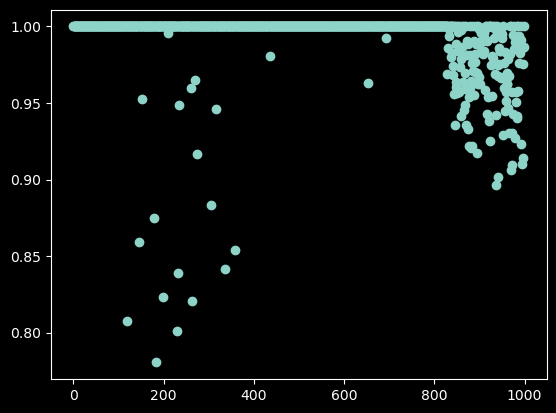

In [16]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# axs[1].scatter(jnp.arange(1500),acceptance_rates_sc)
plt.scatter(jnp.arange(1000),chain_infos.acceptance_rate.mean(axis=1))
# y axis from 0 to 1
# plt.ylim(0.8, 1)

print("mean acc rate : ", jnp.mean(chain_infos.acceptance_rate.mean(axis=1)[0:]))

True expos mean: 2.3902886 
 Posterior expos mean: 2.4048457 
 RMSE expos: 0.116151944


Text(0.5, 1.0, '-Log-posterior over iterations')

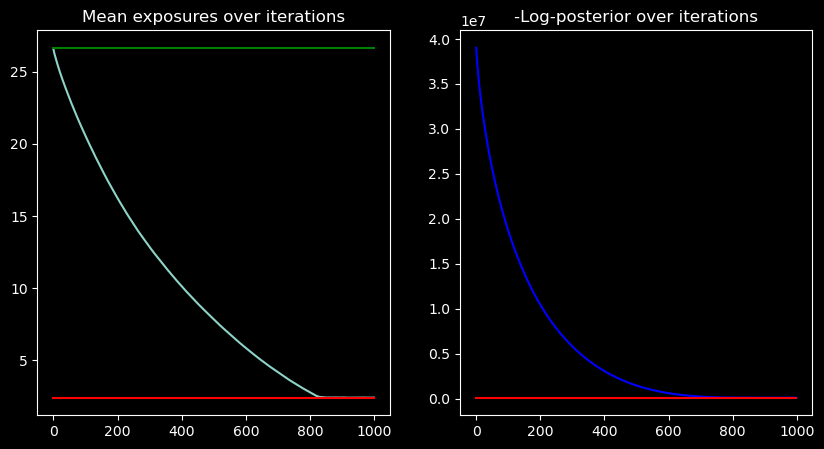

In [17]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print("True expos mean:", data.exposures.mean(), "\n",
      "Posterior expos mean:", expos_arr.mean(axis=1)[-1], "\n",
      "RMSE expos:", jnp.sqrt(jnp.mean((expos_arr[-1] - data.exposures)**2)))

true_logpost, true_grad = post_val_grad_fn(triu_star, data, param)
# true_logpost, true_grad = post_val_grad_fn(triu_star, triu_obs, df_edges,
#                                             theta, gamma, Y, x, Z, eta, sig_y)

# (true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
#                                             theta, gamma, Y, x, Z, eta, sig_y)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
axs[0].plot(expos_arr.mean(axis=1))
axs[0].plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
axs[0].plot(jnp.ones(expos_arr.shape[0])*expos_obs.mean(), color='green')
axs[0].set_title("Mean exposures over iterations")
# axs[0].xticks(range(0, 1500, 100), rotation=90)

axs[1].plot(-jnp.array(chain_states.logdensity), color="blue")
axs[1].plot(-jnp.ones(len(chain_states.logdensity))*true_logpost, color="red")
axs[1].set_title("-Log-posterior over iterations")
# axs[1].xticks(range(0, 1500, 100), rotation=90)


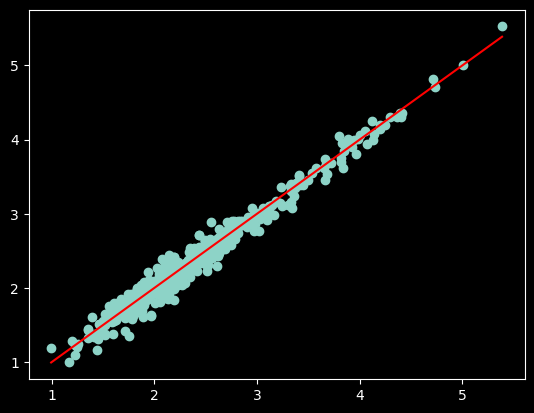

In [18]:
plt.scatter(expos_arr[-1,:], data.exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [19]:
print(np.corrcoef(expos_arr[-1,:], data.exposures))
# print(np.corrcoef(exposures_sc[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), data.exposures))

[[1.         0.98535052]
 [0.98535052 1.        ]]
[[1.         0.18663786]
 [0.18663786 1.        ]]


In [65]:
# print 2x2 table of triu_star and new_triu_star
#  for all values

def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

# print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(data.triu_star, chain_states.positions[-1]))
print(binary_contingency_table(data.triu_star, triu_obs))

# print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(data.triu_star == chain_states.positions[-1]))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(data.triu_star == data.triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 99130 | 13864 |
   1    | 6502 | 5254 |
[[99130 13864]
 [ 6502  5254]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 60513 | 52481 |
   1    | 1121 | 10635 |
[[60513 52481]
 [ 1121 10635]]
0.83674544
0.5703246


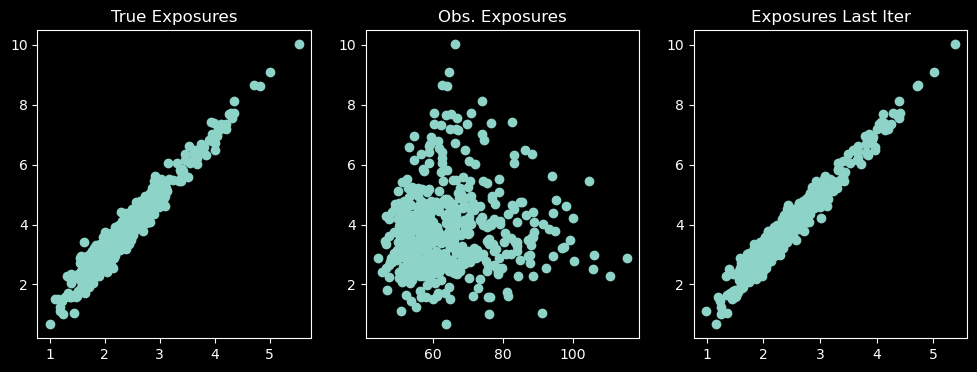

In [68]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z)
plt.title("Exposures Last Iter")
plt.show()


In [22]:
from numpyro.infer.hmc_gibbs import HMCGibbs, HMCGibbsState
from collections import namedtuple
from functools import partial

# Define a state container for GWG kernel
GWGState = namedtuple("GWGState", ["positions", "logdensity", "logdensity_grad", "scores"])

class HMCGibbsGWG(HMCGibbs):
    def __init__(self, inner_kernel, *, step_size=1.0, init_params=None):
        super().__init__(inner_kernel, gibbs_fn=lambda x: x, gibbs_sites=['triu_star'])
        self.step_size = step_size
        self._gwg_state = None
        self._init_params = init_params or {}

    def init(self, rng_key, num_warmup, init_params, model_args, model_kwargs):
        # Combine user-provided init_params with any additional initialization
        combined_init_params = {}
        if init_params is not None:
            combined_init_params.update(init_params)
        if self._init_params is not None:
            combined_init_params.update(self._init_params)

        # Initialize parent state with combined parameters
        state = super().init(rng_key, num_warmup, combined_init_params, model_args, model_kwargs)
        
        # Initialize GWG state using the provided or default triu_star
        z_discrete = {k: v for k, v in state.z.items() if k in self._gibbs_sites}
        triu_star = z_discrete['triu_star']
        
        # Get initial gradient and density

        def potential_fn(z_discrete):
            return self.inner_kernel._potential_fn_gen(
                *model_args, _gibbs_sites=z_discrete, **model_kwargs
            )(state.hmc_state.z)
            
        f_init, grad_init = jax.value_and_grad(potential_fn)(z_discrete)
        scores_init = (-(2*triu_star-1)*grad_init['triu_star'])/2
        
        self._gwg_state = GWGState(
            positions=triu_star,
            logdensity=f_init,
            logdensity_grad=grad_init['triu_star'],
            scores=scores_init
        )
        
        return state
    
    @partial(jax.jit, static_argnums=(0,))
    def _extract_continuous_params(self, state_z):
        """JIT-compiled function to extract continuous parameters"""
        return (
            state_z['theta'],
            state_z['gamma'],
            state_z['eta'],
            state_z['sig_y']
        )
        
    def sample(self, state, model_args, model_kwargs):
        model_kwargs = {} if model_kwargs is None else model_kwargs.copy()
        rng_key, rng_gibbs = random.split(state.rng_key)
        
        # # Extract current continuous parameters
        # z_continuous = {k: v for k, v in state.z.items() if k not in self._gibbs_sites}
        
        # Extract parameters using JIT-compiled function
        theta, gamma, eta, sig_y = self._extract_continuous_params(state.z)
        
        # Run GWG kernel
        new_gwg_state, info = GWG_kernel(
            rng_key=rng_gibbs,
            state=self._gwg_state,
            triu_obs=model_args[0],  # Need to match your model arguments
            df_edges=model_args[1],
            # theta=z_continuous['theta'],
            theta=theta,
            # gamma=z_continuous['gamma'],
            gamma=gamma,
            Y=model_args[4],
            X=model_args[2],
            Z=model_args[3],
            # eta=z_continuous['eta'],
            eta=eta,
            # sig_y=z_continuous['sig_y'],
            sig_y=sig_y,
            step_size=self.step_size
        )
        

        self._gwg_state = new_gwg_state
        
        # Update discrete sites
        # z_gibbs = {'triu_star': new_gwg_state.positions}
        
        # Update HMC state
        # model_kwargs['_gibbs_sites'] = z_gibbs

       # Update HMC state's gibbs sites
        model_kwargs = {} if model_kwargs is None else model_kwargs.copy()
        model_kwargs['_gibbs_sites'] = {'triu_star': new_gwg_state.positions}

        hmc_state = self.inner_kernel.sample(state.hmc_state, model_args, model_kwargs)
        
        # Combine states
        # z = {**z_gibbs, **hmc_state.z}
        
        # return HMCGibbsState(z, hmc_state, rng_key)
        return HMCGibbsState(
        z={**model_kwargs['_gibbs_sites'], **hmc_state.z}, 
        hmc_state=hmc_state,
        rng_key=rng_key
            )

In [23]:
# init_theta = theta + 0.3*random.normal(key, theta.shape)
# init_gamma = gamma + 0.3*random.normal(key, gamma.shape)
# init_eta = eta + 0.3*random.normal(key, eta.shape)
# init_sig_y = jnp.log(sig_y) + 0.3*random.normal(key, (1,))

# # add some noise to triu_star. Note it is binary
# init_triu_star = triu_star * random.bernoulli(key, 0.95, triu_star.shape) + (1-triu_star) * random.bernoulli(key, 0.025, triu_star.shape)
# init_triu_star = jnp.astype(init_triu_star, jnp.int32)

# print("init_theta: ", init_theta, "\n",
#       "init_gamma: ", init_gamma, "\n",
#       "init_eta: ", init_eta, "\n",
#       "init_sig_y: ", init_sig_y, )


# init_params = {
#     # Continuous variables
#     'theta': init_theta,  # Initial theta values
#     'eta': init_eta,  # Initial eta values (assuming 4 covariates)
#     'gamma': init_gamma,  # Initial gamma values
#     'sig_y': init_sig_y,  # Initial sigma_y value
    
#     # Discrete variables
#     'triu_star': init_triu_star  # Your initial binary network
# }


In [24]:

# # Create and run the sampler
# kernel = HMCGibbsGWG(
#     NUTS(combined_model), 
#     step_size=1e-1, 
#     init_params=init_params
# )

# mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
# mcmc.run(
#     random.PRNGKey(0),
#     triu_obs, 
#     df_edges,
#     x,
#     Z,
#     Y
# )

# # TODO: test with init values from cut-posterior

In [69]:
# def network_only_models_marginalized(triu_obs, df_edges):
def network_only_models_marginalized(triu_obs, x_diff, x2_or):
    # priors
    with numpyro.plate("theta_plate", 2):
        theta = numpyro.sample("theta", dist.Normal(0, 3))
        # theta = numpyro.sample("theta", dist.StudentT(df=5, loc=0, scale=2))

    with numpyro.plate("gamma_plate", 3):
        gamma = numpyro.sample("gamma", dist.Normal(0, 3))
        # gamma = numpyro.sample("gamma", dist.StudentT(df=5, loc=0, scale=2))
        
    # with numpyro.plate("u_plate", n):
    #     u = numpyro.sample("u", dist.Normal(0, 1))
    #     # u = numpyro.sample("u", dist.StudentT(df=5, loc=0, scale=2))

    # u_norm = numpyro.deterministic("u_norm", latent_to_norm_of_diff(u))
    # Calculate logits for A*
    star_logits = theta[0] + theta[1]*x2_or
    # star_logits = theta[0] + theta[1]*x2_or - u_norm
    # star_logits = df_edges @ theta
    # star_logits = jnp.clip(star_logits, -30, 30)

    # obs_logits_k0 = df_edges @ gamma[1:]
    obs_logits_k0 = gamma[1] + gamma[2]*x_diff
    # obs_logits_k0 = df_edges[:,:2] @ gamma[1:]


     # Compute log probs directly in log space for efficiency
    # log_nu_k1 = -jnp.log1p(jnp.exp(-star_logits))  # log sigmoid
    log_nu_k1 = star_logits - jnp.log1p(jnp.exp(star_logits))  # log sigmoid
    log_nu_k0 =  - jnp.log1p(jnp.exp(star_logits))  # log(1-sigmoid)
    # log_nu_k0 = -star_logits - jnp.log1p(jnp.exp(-star_logits))  # log(1-sigmoid)
    
    # Same for observation probs
    log_xi_k1 = triu_obs * gamma[0] - jnp.log1p(jnp.exp(gamma[0]))
    log_xi_k0 = triu_obs * obs_logits_k0 - jnp.log1p(jnp.exp(obs_logits_k0))
    

    # get A* posterior probs
    log_numerator = log_xi_k1 + log_nu_k1

    # denominator: sum_{k \in 0,1} xi(A_ij; k,gamma) * nu(k; theta)
    log_denominator = jnp.logaddexp(
        log_xi_k1 + log_nu_k1,
        log_xi_k0 + log_nu_k0
    )
    astar_probs = jnp.exp(log_numerator - log_denominator)
    numpyro.deterministic("triu_star_probs", astar_probs)

    # likelihood term
    numpyro.factor("marginalized_likelihood", log_denominator.sum())



In [70]:
# run svi instead
from numpyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoNormal, AutoDelta, AutoLaplaceApproximation
from numpyro.optim import Adam, ClippedAdam

# marg_guide = AutoLowRankMultivariateNormal(network_only_models_marginalized)
# marg_guide = AutoNormal(network_only_models_marginalized)
# marg_guide = AutoLaplaceApproximation(network_only_models_marginalized)
marg_guide = AutoDelta(network_only_models_marginalized)

svi = SVI(
    model=network_only_models_marginalized,
    guide=marg_guide,
    # optim=Adam(0.01),
    optim=ClippedAdam(0.01),
    # loss=TraceEnum_ELBO()
    loss=TraceGraph_ELBO()
)

rng_key, _ = random.split(key)
svi_result = svi.run(rng_key, 10000, data.triu_obs, data.x_diff, data.x2_or)


100%|██████████| 10000/10000 [00:39<00:00, 256.25it/s, init loss: 86072.2344, avg. loss [9501-10000]: 68367.3510]


In [71]:
marg_parm = marg_guide.median(svi_result.params)
print(marg_parm["theta"], "\n", marg_parm["gamma"])

print("Theta:", param.theta, "\n",
      "Gamma:", param.gamma)

[-2.634241  1.120421] 
 [ 2.5237007 -2.1642811  1.9823532]
Theta: [-2.5  1. ] 
 Gamma: [ 2.1972244 -2.1972246  2.       ]


In [32]:
# Create a Predictive object with the trained guide
predictive = Predictive(network_only_models_marginalized, 
                       guide=marg_guide,
                       params=svi_result.params,
                       num_samples=1)  # since we're using AutoDelta, 1 sample is enough

# Get predictions including the deterministic variables
predictions = predictive(random.split(key)[0], 
                       triu_obs=data.triu_obs,
                       x_diff=data.x_diff,
                       x2_or=data.x2_or)

print(predictions["triu_star_probs"][0].shape)

# plt.hist(predictions["triu_star_probs"][0])

(124750,)


In [33]:
import jax.random as random
from jax import vmap

def sample_posterior_triu_star(key, probs, num_samples=2000):
    """
    Sample Bernoulli realizations for each probability vector in probs
    
    Args:
        key: JAX PRNGKey
        probs: array of shape (n_samples, M) with probabilities
    
    Returns:
        array of shape (n_samples, M) with Bernoulli samples
    """    
    # Split key for each sample
    keys = random.split(key, num_samples)
    
    # Define single sample function
    def sample_single(key):
        return jnp.astype(random.bernoulli(key, probs), jnp.int32)
    
    # Vectorize over samples and probs
    vectorized_sample = vmap(sample_single)
    
    return vectorized_sample(keys)

# Usage:
key = random.split(key)[0]
astar_samples = sample_posterior_triu_star(key,
                                        predictions['triu_star_probs'][0],
                                        2000)
print(f"Samples shape: {astar_samples.shape}")  # Should be (1000, M)

post_marg_expos = vmap_compute_exposures(astar_samples, data.Z)
print(post_marg_expos.shape)

Samples shape: (2000, 124750)
(2000, 500)


In [34]:
def compute_log_posterior(astar_sample, theta, gamma, x2_or, x_diff, triu_obs):
    """Compute log posterior for a single astar configuration"""
    # Prior term (log p(A*|theta))
    star_logits = theta[0] + theta[1]*x2_or
    log_prior = jnp.where(astar_sample == 1, 
                         star_logits - jnp.log1p(jnp.exp(star_logits)),  # log p(A*=1)
                         - jnp.log1p(jnp.exp(star_logits)))  # log p(A*=0)
    
    # Likelihood term (log p(A|A*,gamma))
    obs_logits_k0 = gamma[1] + gamma[2]*x_diff
    log_lik = jnp.where(astar_sample == 1,
                        triu_obs * gamma[0] - jnp.log1p(jnp.exp(gamma[0])),  # when A*=1
                        triu_obs * obs_logits_k0 - jnp.log1p(jnp.exp(obs_logits_k0)))  # when A*=0
    
    return jnp.sum(log_prior + log_lik)

# Vectorize over samples
compute_log_posterior_vmap = vmap(compute_log_posterior, 
                                in_axes=(0, None, None, None, None, None))

# Compute log posterior for all samples
log_posteriors = compute_log_posterior_vmap(astar_samples, 
                                          marg_guide.median(svi_result.params)["theta"], 
                                          marg_guide.median(svi_result.params)["gamma"],
                                          data.x2_or,
                                          data.x_diff,
                                          data.triu_obs)
# Find sample with highest posterior
best_idx = jnp.argmax(log_posteriors)
best_astar = astar_samples[best_idx]

best_expos = compute_exposures(best_astar, data.Z)

RMSE exposures:  0.41420192 
 RMSE best exposures:  0.575931 
 Mean exposures:  2.310859 
 Mean best exposures:  2.224433 
 True exposures:  2.3902886 
 corr post mean and true:  0.798288 
 corr best and true:  0.6601111


Text(0, 0.5, 'Best exposures')

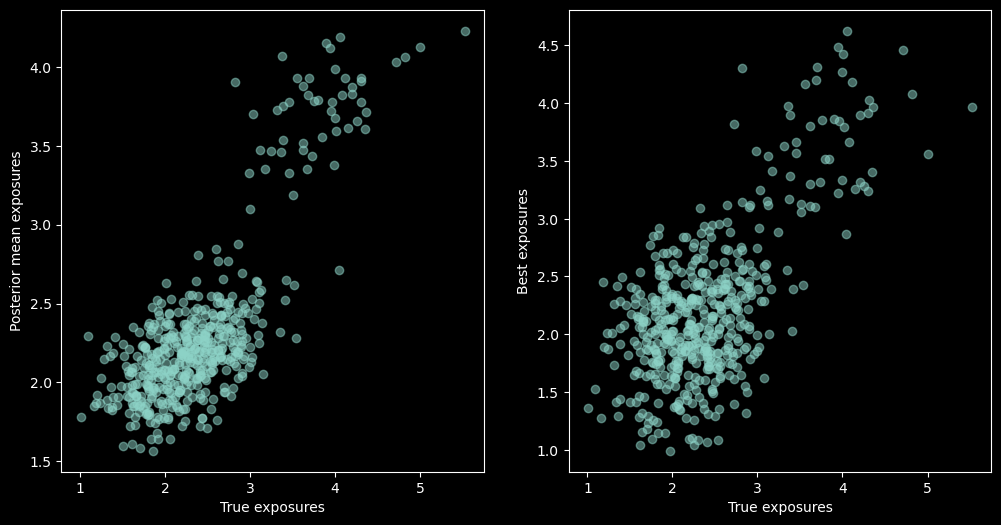

In [35]:
# rmse_expos = jnp.sqrt(jnp.mean((exposures - post_marg_expos)**2))
rmse_expos = jnp.sqrt(jnp.mean((data.exposures - post_marg_expos.mean(axis=0))**2))
mean_expos_svi = post_marg_expos.mean(axis=0) 

rmse_best_expos = jnp.sqrt(jnp.mean((data.exposures - best_expos)**2))
mean_best_expos = best_expos.mean()
print("RMSE exposures: ", rmse_expos, "\n",
      "RMSE best exposures: ", rmse_best_expos, "\n",
      "Mean exposures: ", mean_expos_svi.mean(), "\n",
      "Mean best exposures: ", mean_best_expos, "\n",
      "True exposures: ", data.exposures.mean(), "\n",
      "corr post mean and true: ", jnp.corrcoef(mean_expos_svi, data.exposures)[0,1], "\n",
      "corr best and true: ", jnp.corrcoef(best_expos, data.exposures)[0,1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(data.exposures, post_marg_expos.mean(axis=0), alpha=0.5)
axs[0].set_xlabel("True exposures")
axs[0].set_ylabel("Posterior mean exposures")

axs[1].scatter(data.exposures, best_expos, alpha=0.5)
axs[1].set_xlabel("True exposures")
axs[1].set_ylabel("Best exposures")



In [42]:
# Plugin outcome model

def plugin_outcome_model(df_nodes, adj_mat, Y):
    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 3))
    
    # sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    
    rho = numpyro.sample("rho", dist.Beta(2,2))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))
    # sig_inv = numpyro.sample("sig_inv", dist.HalfNormal(2))

    # likelihood
    mean_y = df_nodes @ eta

    numpyro.sample("Y", dist.CAR(loc=mean_y,
                            correlation=rho,
                            conditional_precision=sig_inv,
                            adj_matrix=adj_mat),
                            obs=Y)

    # numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)

# Run NUTS
df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), data.Z, data.x, mean_expos_svi]))
# df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, best_expos]))
rng_key, _ = random.split(key)
kernel_plugin = NUTS(plugin_outcome_model)
mcmc_plugin = MCMC(kernel_plugin, num_warmup=2000, num_samples=2500, 
                    num_chains=4, chain_method='parallel', progress_bar=True)
mcmc_plugin.run(rng_key, df_nodes, aux.Triu_to_mat(best_astar), data.Y)
mcmc_plugin.print_summary()

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.90      0.16     -0.90     -1.15     -0.64   6435.92      1.00
    eta[1]      3.02      0.07      3.02      2.91      3.15  10718.02      1.00
    eta[2]     -0.22      0.04     -0.22     -0.29     -0.16  11416.45      1.00
    eta[3]      2.03      0.05      2.03      1.94      2.12   7038.14      1.00
       rho      0.59      0.20      0.61      0.27      0.91   9025.01      1.00
   sig_inv      0.03      0.00      0.03      0.03      0.04  11035.44      1.00

Number of divergences: 0


In [43]:
init_theta = marg_guide.median(svi_result.params)["theta"]
init_gamma = marg_guide.median(svi_result.params)["gamma"]
init_eta = mcmc_plugin.get_samples()["eta"].mean(axis=0)
# init_eta = plugin_parm["eta"]
init_sig_inv = mcmc_plugin.get_samples()["sig_inv"].mean()
init_rho = mcmc_plugin.get_samples()["rho"].mean()
# init_sig_y = plugin_parm["sig_y"]

init_triu_star = best_astar

init_params = {
    # Continuous variables
    'theta': init_theta,  # Initial theta values
    'eta': init_eta,  # Initial eta values (assuming 4 covariates)
    'gamma': init_gamma,  # Initial gamma values
    # 'sig_y': init_sig_y,  # Initial sigma_y value
    "rho": init_rho,
    "sig_inv": init_sig_inv,
    # Discrete variables
    'triu_star': init_triu_star  # Your initial binary network
}

print(init_params)

print("theta: ", param.theta, "\n",
      "gamma: ", param.gamma, "\n",
      "eta: ", param.eta, "\n",
    #   "sig_y: ", param.sig_y)
        "sig_inv: ", param.sig_inv, "\n",
        "rho: ", param.rho)



{'theta': Array([-2.5461154,  1.060114 ], dtype=float32), 'eta': Array([-0.9024158 ,  3.0217571 , -0.22121073,  2.02953   ], dtype=float32), 'gamma': Array([ 2.4663389, -2.206038 ,  1.0077647], dtype=float32), 'rho': Array(0.59418076, dtype=float32), 'sig_inv': Array(0.03244722, dtype=float32), 'triu_star': Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}
theta:  [-2.5  1. ] 
 gamma:  [ 2.1972244 -2.1972246  1.       ] 
 eta:  [-1.    3.   -0.25  2.  ] 
 sig_inv:  0.6666666666666666 
 rho:  0.5


In [44]:
# Continuous relaxation with Gumbel-softmax
#  OR MWG (NUTS + GWG) via numpyro's HMCGibbs


# temp = .1


def combined_model(triu_obs, x_diff, x2_or, X, Z, Y=None):
    # True network model 
    # priors
    with numpyro.plate("theta_plate", 2):
        theta = numpyro.sample("theta", dist.Normal(0, 3))

    # likelihood

    # temp = numpyro.sample("temp", dist.Exponential(2.0))
    # star_logits = df_edges @ theta
    star_logits = theta[0] + theta[1]*x2_or
    triu_star = numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits))

    # with numpyro.plate("triu_star_plate", triu_obs.shape[0]):
    #     triu_star =  numpyro.sample("triu_star", dist.RelaxedBernoulliLogits(temperature=temp,
    #                                                         logits=star_logits))
    # triu_star = numpyro.sample("triu_star", dist.RelaxedBernoulliLogits(temperature=temp,
                                                        # logits=star_logits))

    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    
    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 3))
    
    rho = numpyro.sample("rho", dist.Beta(2,2))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))
    
    adj_mat = aux.Triu_to_mat(triu_star)
    
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    # sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=1.0))
    # sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    # numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    numpyro.sample("Y", dist.CAR(loc=mean_y,
                            correlation=rho,
                            conditional_precision=sig_inv,
                            adj_matrix=adj_mat),
                            obs=Y)
    
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 3):
        gamma = numpyro.sample("gamma", dist.Normal(0, 3))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (gamma[1] + gamma[2]*x_diff)
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

In [45]:
def make_gwg_gibbs_fn(data):
    # Create a closure over the fixed data
    
    @jax.jit  # Can JIT since data is fixed in closure
    def gwg_gibbs_fn(rng_key, gibbs_sites, hmc_sites):
        # Get current state of triu_star
        # triu_star = jnp.array(gibbs_sites['triu_star'], dtype=jnp.float32)
        cur_triu_star = jnp.astype(gibbs_sites['triu_star'], jnp.float32)
        
        # Get current values of continuous parameters
        cur_param = ParamTuple(
            theta=hmc_sites['theta'],
            gamma=hmc_sites['gamma'],
            eta=hmc_sites['eta'],
            # sig_y=hmc_sites['sig_y']     
            rho=hmc_sites["rho"],       
            sig_inv=hmc_sites["sig_inv"]
        )


        
        # Create/update IPState 
        cur_logdensity, cur_grad = post_val_grad_fn(
            cur_triu_star,
            data,
            cur_param
        )

        cur_scores = (-(2*cur_triu_star-1)*cur_grad)/2
        
        state = IPState(
            positions=cur_triu_star,
            logdensity=cur_logdensity,
            logdensity_grad=cur_grad,
            scores=cur_scores
        )
        
        # Run GWG step
        new_state, _ = GWG_kernel(
            rng_key=rng_key,
            state=state,
            data=data,
            param=cur_param
            )
        
        # Return only the new positions as required by HMCGibbs
        # return {'triu_star': jnp.array(new_state.positions, dtype=jnp.int32)}
        return {'triu_star': jnp.astype(new_state.positions, jnp.int32)}
    
    return gwg_gibbs_fn



In [46]:
def replicate_params(init_params, num_chains):
    return jax.tree.map(
        lambda x: jnp.repeat(x[None], num_chains, axis=0),
        init_params
    )

rep_init_params = replicate_params(init_params, 4)
print(rep_init_params)


{'eta': Array([[-0.9024158 ,  3.0217571 , -0.22121073,  2.02953   ],
       [-0.9024158 ,  3.0217571 , -0.22121073,  2.02953   ],
       [-0.9024158 ,  3.0217571 , -0.22121073,  2.02953   ],
       [-0.9024158 ,  3.0217571 , -0.22121073,  2.02953   ]],      dtype=float32), 'gamma': Array([[ 2.4663389, -2.206038 ,  1.0077647],
       [ 2.4663389, -2.206038 ,  1.0077647],
       [ 2.4663389, -2.206038 ,  1.0077647],
       [ 2.4663389, -2.206038 ,  1.0077647]], dtype=float32), 'rho': Array([0.59418076, 0.59418076, 0.59418076, 0.59418076], dtype=float32), 'sig_inv': Array([0.03244722, 0.03244722, 0.03244722, 0.03244722], dtype=float32), 'theta': Array([[-2.5461154,  1.060114 ],
       [-2.5461154,  1.060114 ],
       [-2.5461154,  1.060114 ],
       [-2.5461154,  1.060114 ]], dtype=float32), 'triu_star': Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}


In [47]:
from numpyro.infer.hmc_gibbs import HMCGibbs

# Usage:
gibbs_fn = make_gwg_gibbs_fn(data)
# kernel_hmc_gwg = HMCGibbs(HMC(combined_model), gibbs_fn=gibbs_fn, gibbs_sites=['triu_star'])
kernel_hmc_gwg = HMCGibbs(NUTS(combined_model), 
                          gibbs_fn=gibbs_fn,
                          gibbs_sites=['triu_star'])
mcmc_hmc_gwg = MCMC(kernel_hmc_gwg, num_warmup=2000, num_samples=2500, num_chains=4)
mcmc_hmc_gwg.run(random.split(key)[0], data.triu_obs, data.x_diff, data.x2_or, data.x, data.Z, data.Y,
                  init_params = rep_init_params)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

In [48]:
mwg_samples = mcmc_hmc_gwg.get_samples()
print(mwg_samples.keys())

dict_keys(['eta', 'gamma', 'rho', 'sig_inv', 'theta', 'triu_star'])


In [49]:
print("mean eta: ", mwg_samples["eta"].mean(axis=0), "\n",
        "mean gamma: ", mwg_samples["gamma"].mean(axis=0), "\n",
        "mean theta: ", mwg_samples["theta"].mean(axis=0), "\n",
        "mean rho: ", mwg_samples["rho"].mean(axis=0), "\n",
        "mean sig_inv: ", mwg_samples["sig_inv"].mean(axis=0))

mean eta:  [-0.52667713  3.077938   -0.21770659  1.8942492 ] 
 mean gamma:  [ 2.37797   -2.1934826  1.0031297] 
 mean theta:  [-2.571839   1.1016073] 
 mean rho:  0.5178117 
 mean sig_inv:  0.14788388


In [50]:
# vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
post_expos = vmap_compute_exposures(mwg_samples["triu_star"], data.Z)
print(post_expos.shape)
post_mean_expos = post_expos.mean(axis=0)
print(post_mean_expos.shape)


(10000, 500)
(500,)


mean true expos:  2.3902886 
 mean init expos:  2.310859 
 mean post expos:  2.2611997
corr true vs init:  [[1.         0.79828798]
 [0.79828798 1.        ]] 
 corr true vs post (mean):  [[1.         0.98130209]
 [0.98130209 1.        ]]
corr Y with true expos:  [[1.         0.66150239]
 [0.66150239 1.        ]] 
 corr Y with init expos:  [[1.         0.51436077]
 [0.51436077 1.        ]] 
 corr Y with post (mean) expos:  [[1.         0.63978368]
 [0.63978368 1.        ]]


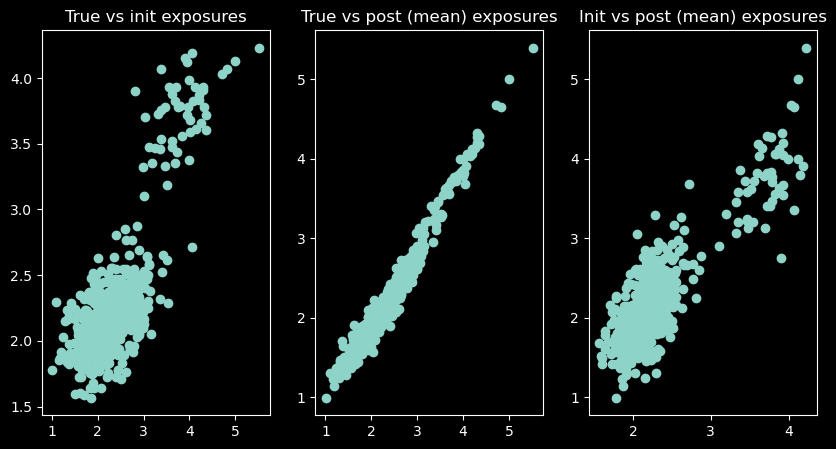

In [51]:

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(data.exposures, mean_expos_svi)
axs[0].set_title("True vs init exposures")

axs[1].scatter(data.exposures, post_mean_expos)
axs[1].set_title("True vs post (mean) exposures")

axs[2].scatter(mean_expos_svi, post_mean_expos)
axs[2].set_title("Init vs post (mean) exposures")

print("mean true expos: ", data.exposures.mean(), "\n",
        "mean init expos: ", mean_expos_svi.mean(), "\n",
        "mean post expos: ", post_mean_expos.mean())

print("corr true vs init: ", np.corrcoef(data.exposures, mean_expos_svi), "\n",
      "corr true vs post (mean): ", np.corrcoef(data.exposures, post_mean_expos))
print("corr Y with true expos: ", np.corrcoef(data.Y, data.exposures), "\n",
      "corr Y with init expos: ", np.corrcoef(data.Y, mean_expos_svi), "\n",
      "corr Y with post (mean) expos: ", np.corrcoef(data.Y, post_mean_expos))

(500,) (10000, 500)
(500,)
mean true degrees:  47.024002 
 mean init degrees:  45.056004 
 mean post degrees:  45.8489
corr true vs init:  [[1.         0.85624925]
 [0.85624925 1.        ]] 
 corr true vs post (mean):  [[1.         0.94188279]
 [0.94188279 1.        ]]


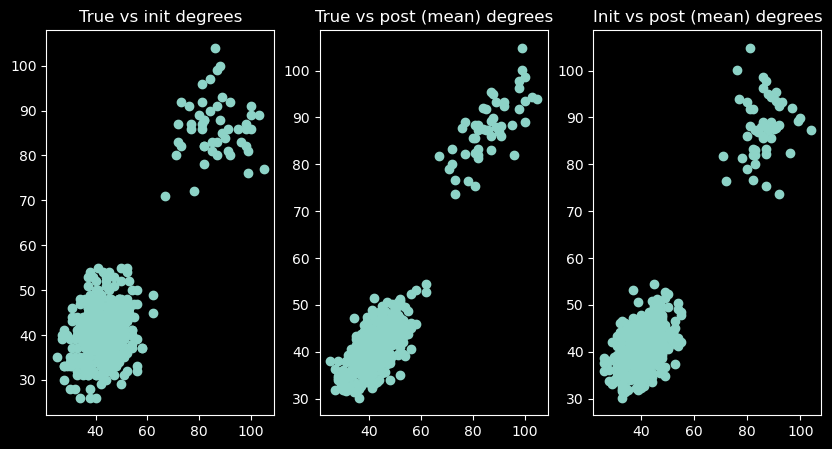

In [52]:
init_deg = jnp.sum(aux.Triu_to_mat(init_triu_star), axis=1)
vmap_triu_to_mat = jax.vmap(aux.Triu_to_mat, in_axes=(0,))
post_deg = jnp.sum(vmap_triu_to_mat(mwg_samples["triu_star"]), axis=-1)
print(init_deg.shape, post_deg.shape)
post_deg_mean = post_deg.mean(axis=0)
print(post_deg_mean.shape)
true_deg = jnp.sum(aux.Triu_to_mat(data.triu_star), axis=1)

figs, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(true_deg, init_deg)
axs[0].set_title("True vs init degrees")

axs[1].scatter(true_deg, post_deg_mean)
axs[1].set_title("True vs post (mean) degrees")

axs[2].scatter(init_deg, post_deg_mean)
axs[2].set_title("Init vs post (mean) degrees")

print("mean true degrees: ", true_deg.mean(), "\n",
        "mean init degrees: ", init_deg.mean(), "\n",
        "mean post degrees: ", post_deg_mean.mean())

print("corr true vs init: ", np.corrcoef(true_deg, init_deg), "\n",
        "corr true vs post (mean): ", np.corrcoef(true_deg, post_deg_mean))



5.387736


(array([ 1.,  2.,  4.,  5., 11., 10., 19., 29., 44., 47., 38., 52., 50.,
        60., 58., 36., 10., 12.,  7.,  5.]),
 array([-2.06212449, -1.41202426, -0.76192409, -0.1118239 ,  0.53827631,
         1.18837643,  1.83847666,  2.48857689,  3.13867712,  3.78877735,
         4.43887758,  5.08897781,  5.73907804,  6.38917828,  7.03927803,
         7.68937826,  8.33947849,  8.9895792 ,  9.63967896, 10.28977966,
        10.93987942]),
 <BarContainer object of 20 artists>)

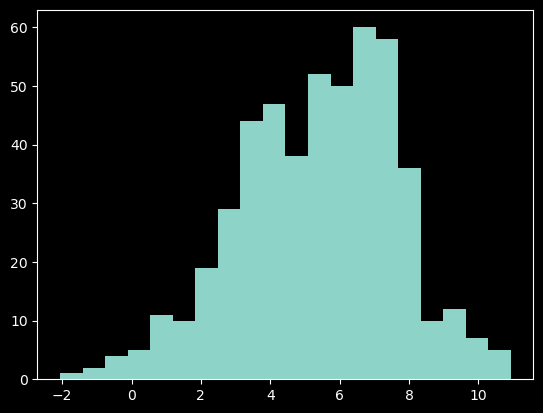

In [53]:
new_Z1 = jnp.array(rng.binomial(1, 0.7, (n, )), dtype=jnp.float32)
new_Z2 = jnp.array(rng.binomial(1, 0.3, (n, )), dtype=jnp.float32)
new_Z_diff = new_Z1 - new_Z2

new_expos1 = compute_exposures(data.triu_star, new_Z1)
new_expos2 = compute_exposures(data.triu_star, new_Z2)
new_expos_diff = new_expos1 - new_expos2

true_estimand = eta[1]*new_Z_diff + eta[3]*new_expos_diff
print(true_estimand.mean())
plt.hist(true_estimand, bins=20)

In [54]:
# posterior estimates

post_expos1 = vmap_compute_exposures(mwg_samples["triu_star"], new_Z1)
post_expos2 = vmap_compute_exposures(mwg_samples["triu_star"], new_Z2)
post_expos_diff = post_expos1 - post_expos2

post_estimates = mwg_samples["eta"][:,1][:,None]*new_Z_diff[None,:] + mwg_samples["eta"][:,3][:,None]*post_expos_diff
print(post_estimates.shape)

(10000, 500)


In [74]:
# testing CAR in numpyro

def car_outcome_model(data):
    with numpyro.plate("eta_plate", 4):
        eta = numpyro.sample("eta", dist.Normal(0, 5))

    rho = numpyro.sample("rho", dist.Beta(2,2))

    sig_inv = numpyro.sample("sig_inv", dist.Gamma(2,2))

    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), data.Z, data.x, data.exposures]))

    mean_y = df_nodes @ eta
    # first try with CAR dist

    numpyro.sample("Y", dist.CAR(loc=mean_y,
                                correlation=rho,
                                conditional_precision=sig_inv,
                                adj_matrix=aux.Triu_to_mat(data.triu_star)),
                                obs=data.Y)


# NUTS sampler

nuts_kernel = NUTS(car_outcome_model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2500,
            num_chains=4)

mcmc.run(random.PRNGKey(5), data)
mcmc.print_summary()

car_samps = mcmc.get_samples()

# get estimates
car_estimates = car_samps["eta"][:,1][:,None]*new_Z_diff[None,:] + car_samps["eta"][:,3][:,None]*new_expos_diff

print(car_estimates.shape)



  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]     -0.98      0.03     -0.98     -1.03     -0.93   6187.76      1.00
    eta[1]      3.00      0.02      3.00      2.98      3.03  11263.32      1.00
    eta[2]     -0.25      0.01     -0.25     -0.27     -0.24  11436.07      1.00
    eta[3]      1.99      0.01      1.99      1.98      2.01   6404.78      1.00
       rho      0.47      0.21      0.46      0.13      0.81   9272.04      1.00
   sig_inv      0.66      0.04      0.66      0.59      0.72  11731.09      1.00

Number of divergences: 0
(10000, 500)


In [80]:
# CAR with observed data

obs_expos = compute_exposures(data.triu_obs, data.Z)

obs_data = DataTuple(
    x=data.x,
    x2=data.x2,
    x_diff=data.x_diff,
    x2_or=data.x2_or,
    triu_star=data.triu_obs,
    triu_obs=data.triu_obs,
    Z=data.Z,
    exposures=obs_expos,
    Y=data.Y    
)

mcmc_obs = MCMC(nuts_kernel, num_warmup=2000, num_samples=2500,
            num_chains=4)


mcmc_obs.run(random.PRNGKey(5), obs_data)
mcmc_obs.print_summary()

car_samps_obs = mcmc_obs.get_samples()

# new expos obs
obs_expos1 = compute_exposures(data.triu_obs, new_Z1)
obs_expos2 = compute_exposures(data.triu_obs, new_Z2)
obs_expos_diff = obs_expos1 - obs_expos2

# get estimates
car_estimates_obs = car_samps_obs["eta"][:,1][:,None]*new_Z_diff[None,:] + car_samps_obs["eta"][:,3][:,None]*obs_expos_diff

print(car_estimates_obs.shape)

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]      3.01      0.29      3.00      2.55      3.50   5054.89      1.00
    eta[1]      3.03      0.12      3.03      2.82      3.23   7819.53      1.00
    eta[2]     -0.20      0.06     -0.20     -0.29     -0.10   8712.49      1.00
    eta[3]      0.03      0.01      0.03      0.01      0.04   5057.33      1.00
       rho      0.37      0.20      0.34      0.04      0.68   6768.07      1.00
   sig_inv      0.00      0.00      0.00      0.00      0.00   7967.71      1.00

Number of divergences: 0
(10000, 500)


RMSE:  0.29105827 
 Rel RMSE:  0.057871256 
 MAE:  0.2645102 
 MAPE:  0.049094878 
 Bias:  -0.26320982 
 Coverage:  0.0 
 q025, q975:  4.898433 5.371738 
 Ind Coverage:  0.882 
 mean true estimand:  5.387736 
 mean post estimand:  5.124526 



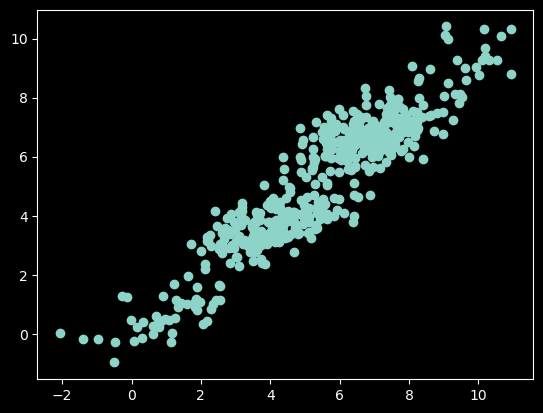

In [89]:
# rmse_esti = jnp.sqrt(jnp.mean((true_estimand - post_estimates.mean(axis=0))**2))
rmse_esti = jnp.sqrt(jnp.mean((true_estimand.mean() - post_estimates.mean(axis=1))**2))
rel_rmse = jnp.sqrt(jnp.mean(((true_estimand.mean() - post_estimates.mean(axis=1))/
                              post_estimates.mean(axis=1))**2))
# rel_rmse = jnp.sqrt(jnp.mean(((true_estimand - post_estimates.mean(axis=0))/
#                               post_estimates.mean(axis=0))**2))

mape = jnp.mean(jnp.abs((true_estimand.mean() - post_estimates.mean(axis=1))/true_estimand.mean()))
mae = jnp.mean(jnp.abs(true_estimand.mean() - post_estimates.mean(axis=1)))

bias_esti = jnp.mean(post_estimates) - jnp.mean(true_estimand)
q025_ind, q975_ind = jnp.quantile(post_estimates, q=jnp.array([0.025, 0.975]), axis=0)
coverage_ind = jnp.mean((q025_ind <= true_estimand) & (true_estimand <= q975_ind))
q025, q975 = jnp.quantile(post_estimates.mean(axis=1), q=jnp.array([0.025, 0.975]))
coverage = jnp.mean((q025 <= true_estimand.mean()) & (true_estimand.mean() <= q975))

print("RMSE: ", rmse_esti, "\n",
        "Rel RMSE: ", rel_rmse, "\n",
        "MAE: ", mae, "\n",
        "MAPE: ", mape, "\n",
        "Bias: ", bias_esti, "\n",
        "Coverage: ", coverage, "\n",
        "q025, q975: ", q025, q975, "\n",
        "Ind Coverage: ", coverage_ind, "\n",
        "mean true estimand: ", true_estimand.mean(), "\n",
        "mean post estimand: ", post_estimates.mean(), "\n")

plt.scatter(true_estimand, post_estimates.mean(axis=0))

RMSE:  3.472174 
 Rel RMSE:  1.8822379 
 MAE:  3.4640577 
 MAPE:  0.6429523 
 Bias:  -3.4640572 
 Coverage:  0.0 
 q025, q975:  1.4578993 2.3862472 
 Ind Coverage:  0.002 
 mean true estimand:  5.387736 
 mean post estimand:  1.9236786 



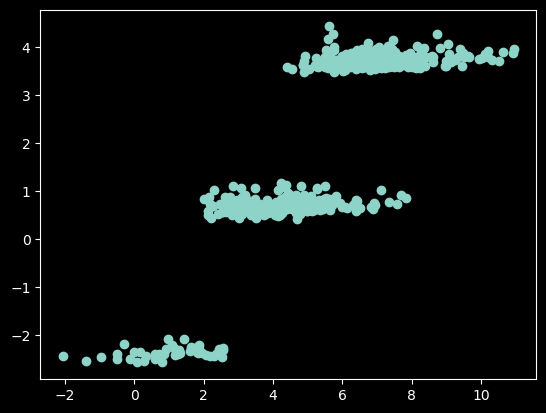

In [88]:
# repeate for car_estimates_obs

rmse_esti_obs = jnp.sqrt(jnp.mean((true_estimand.mean() - car_estimates_obs.mean(axis=1))**2))
rel_rmse_obs = jnp.sqrt(jnp.mean(((true_estimand.mean() - car_estimates_obs.mean(axis=1))/
                              car_estimates_obs.mean(axis=1))**2))

mape_obs = jnp.mean(jnp.abs((true_estimand.mean() - car_estimates_obs.mean(axis=1))/true_estimand.mean()))
mae_obs = jnp.mean(jnp.abs(true_estimand.mean() - car_estimates_obs.mean(axis=1)))

bias_esti_obs = jnp.mean(car_estimates_obs) - jnp.mean(true_estimand)
q025_ind_obs, q975_ind_obs = jnp.quantile(car_estimates_obs, q=jnp.array([0.025, 0.975]), axis=0)
coverage_ind_obs = jnp.mean((q025_ind_obs <= true_estimand) & (true_estimand <= q975_ind_obs))
q025_obs, q975_obs = jnp.quantile(car_estimates_obs.mean(axis=1), q=jnp.array([0.025, 0.975]))
coverage_obs = jnp.mean((q025_obs <= true_estimand.mean()) & (true_estimand.mean() <= q975_obs))

print("RMSE: ", rmse_esti_obs, "\n",
        "Rel RMSE: ", rel_rmse_obs, "\n",
        "MAE: ", mae_obs, "\n",
        "MAPE: ", mape_obs, "\n",
        "Bias: ", bias_esti_obs, "\n",
        "Coverage: ", coverage_obs, "\n",
        "q025, q975: ", q025_obs, q975_obs, "\n",
        "Ind Coverage: ", coverage_ind_obs, "\n",
        "mean true estimand: ", true_estimand.mean(), "\n",
        "mean post estimand: ", car_estimates_obs.mean(), "\n")

plt.scatter(true_estimand, car_estimates_obs.mean(axis=0))



RMSE:  0.02517962 
 Rel RMSE:  0.004699725 
 MAE:  0.020215457 
 MAPE:  0.0037521247 
 Bias:  -0.011411667 
 Coverage:  1.0 
 q025, q975:  5.3325706 5.4199977 
 Ind Coverage:  1.0 
 mean true estimand:  5.387736 
 mean post estimand:  5.376324 



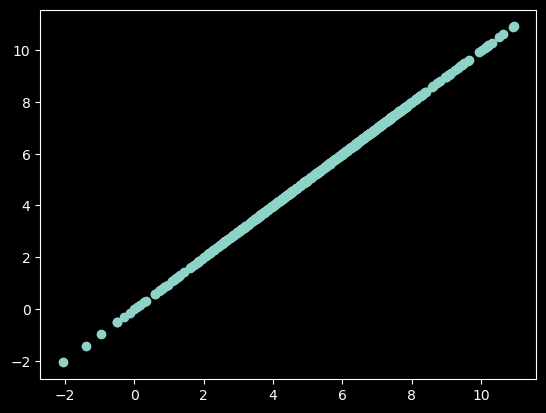

In [87]:
# repeated for car_estimates

rmse_esti_car = jnp.sqrt(jnp.mean((true_estimand.mean() - car_estimates.mean(axis=1))**2))
rel_rmse_car = jnp.sqrt(jnp.mean(((true_estimand.mean() - car_estimates.mean(axis=1))/
                              car_estimates.mean(axis=1))**2))

mape_car = jnp.mean(jnp.abs((true_estimand.mean() - car_estimates.mean(axis=1))/true_estimand.mean()))
mae_car = jnp.mean(jnp.abs(true_estimand.mean() - car_estimates.mean(axis=1)))

bias_esti_car = jnp.mean(car_estimates) - jnp.mean(true_estimand)

q025_ind_car, q975_ind_car = jnp.quantile(car_estimates, q=jnp.array([0.025, 0.975]), axis=0)
coverage_ind_car = jnp.mean((q025_ind_car <= true_estimand) & (true_estimand <= q975_ind_car))

q025_car, q975_car = jnp.quantile(car_estimates.mean(axis=1), q=jnp.array([0.025, 0.975]))
coverage_car = jnp.mean((q025_car <= true_estimand.mean()) & (true_estimand.mean() <= q975_car))

print("RMSE: ", rmse_esti_car, "\n",
        "Rel RMSE: ", rel_rmse_car, "\n",
        "MAE: ", mae_car, "\n",
        "MAPE: ", mape_car, "\n",
        "Bias: ", bias_esti_car, "\n",
        "Coverage: ", coverage_car, "\n",
        "q025, q975: ", q025_car, q975_car, "\n",
        "Ind Coverage: ", coverage_ind_car, "\n",
        "mean true estimand: ", true_estimand.mean(), "\n",
        "mean post estimand: ", car_estimates.mean(), "\n")

plt.scatter(true_estimand, car_estimates.mean(axis=0))

# TODO: init with cut-posterior (manual enumeration works best)
#       init theta and gamma are MAP. init triu_star is one with maximal log-posterior
#       plug-in outcome model with mean exposures of posterior triu_stars (from NUTS)

# TODO: clean code and wrap everything in functions

# TODO: sim structure:
#      - use this DGP and change $\gamma[2]$ values to create weaker signals 
#      - Maybe have the option of two observed nets (repeated measures) 
#           and compare performance of using one versus two proxies.

